In [2]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanaynagarkar","key":"16dbf0042ffb796fb13d284bda07be50"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d tanaynagarkar/pc3-data -p /content/
!unzip -q /content/pc3-data.zip -d /content/PC3_data


Dataset URL: https://www.kaggle.com/datasets/tanaynagarkar/pc3-data
License(s): CC0-1.0
 99% 3.00G/3.02G [00:31<00:00, 254MB/s]
100% 3.02G/3.02G [00:31<00:00, 104MB/s]


In [5]:
!pip install git+https://github.com/facebookresearch/sam2.git -q
!pip install ultralytics opencv-python matplotlib tqdm torch torchvision -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.8 MB/s eta 0:00:00


In [7]:
import os, cv2, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from ultralytics import SAM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_img_dir = "/content/PC3_data/PC3_data_split/train/images"
train_mask_dir = "/content/PC3_data/PC3_data_split/train/masks"
test_img_dir = "/content/PC3_data/PC3_data_split/test/images"
test_mask_dir = "/content/PC3_data/PC3_data_split/test/masks"

class XrayDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, self.masks[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        img = img.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)
        img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), torch.tensor(mask).unsqueeze(0)

train_dataset = XrayDataset(train_img_dir, train_mask_dir)
test_dataset = XrayDataset(test_img_dir, test_mask_dir)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)


base_sam = SAM("sam2.1_l.pt")
sam_model = base_sam.model.to(device)
print("SAM2.1-L base model loaded successfully!")


with torch.no_grad():
    sample_x, _ = next(iter(train_loader))
    sample_x = sample_x.to(device)
    feats = sam_model.image_encoder(sample_x)
    if isinstance(feats, dict):
        feats = list(feats.values())[0]
    feat_channels = feats.shape[1]
    feat_h, feat_w = feats.shape[2], feats.shape[3]


class FineTuneSAM(nn.Module):
    def __init__(self, sam_base, in_channels, out_size=(256, 256)):
        super().__init__()
        self.encoder = sam_base.image_encoder
        self.out_size = out_size
        self.dec = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
            if isinstance(features, dict):
                feats = list(features.values())[0]
            else:
                feats = features
        out = self.dec(feats)
        out = nn.functional.interpolate(out, size=self.out_size, mode='bilinear', align_corners=False)
        return torch.sigmoid(out)


class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)
        smooth = 1e-7
        intersection = (preds * targets).sum()
        dice_loss = 1 - ((2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth))
        return 0.5 * bce_loss + 0.5 * dice_loss


model = FineTuneSAM(sam_model, in_channels=feat_channels, out_size=(256, 256)).to(device)
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(40):
    model.train()
    total_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/40"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Avg Loss: {total_loss / len(train_loader):.6f}")


os.makedirs("/content/drive/MyDrive", exist_ok=True)
torch.save(model.state_dict(), "/content/drive/MyDrive/sam2L_finetuned_xray.pt")
print("Model saved at /content/drive/MyDrive/sam2L_finetuned_xray.pt")


def compute_metrics(pred, mask):
    pred_bin = (pred > 0.5).float()
    intersection = (pred_bin * mask).sum()
    union = pred_bin.sum() + mask.sum() - intersection
    iou = (intersection / (union + 1e-7)).item()
    dice = ((2 * intersection) / (pred_bin.sum() + mask.sum() + 1e-7)).item()
    tp = (pred_bin * mask).sum().item()
    fp = (pred_bin * (1 - mask)).sum().item()
    fn = ((1 - pred_bin) * mask).sum().item()
    tn = ((1 - pred_bin) * (1 - mask)).sum().item()
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    specificity = tn / (tn + fp + 1e-7)
    return iou, dice, precision, recall, specificity

iou_list, dice_list, pre_list, rec_list, spec_list = [], [], [], [], []
model.eval()
with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Evaluating"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        for i in range(preds.shape[0]):
            iou, dice, p, r, s = compute_metrics(preds[i], masks[i])
            iou_list.append(iou)
            dice_list.append(dice)
            pre_list.append(p)
            rec_list.append(r)
            spec_list.append(s)

print(f"IoU={np.mean(iou_list):.4f}, Dice={np.mean(dice_list):.4f}, "
      f"Precision={np.mean(pre_list):.4f}, Recall={np.mean(rec_list):.4f}, Specificity={np.mean(spec_list):.4f}")


Using device: cuda
SAM2.1-L base model loaded successfully!


Epoch 1/40: 100%|██████████| 226/226 [00:52<00:00,  4.29it/s]


Epoch 1 | Avg Loss: 0.150656


Epoch 2/40: 100%|██████████| 226/226 [00:52<00:00,  4.27it/s]


Epoch 2 | Avg Loss: 0.086096


Epoch 3/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 3 | Avg Loss: 0.075784


Epoch 4/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 4 | Avg Loss: 0.071033


Epoch 5/40: 100%|██████████| 226/226 [00:53<00:00,  4.23it/s]


Epoch 5 | Avg Loss: 0.068415


Epoch 6/40: 100%|██████████| 226/226 [00:51<00:00,  4.35it/s]


Epoch 6 | Avg Loss: 0.064774


Epoch 7/40: 100%|██████████| 226/226 [00:52<00:00,  4.27it/s]


Epoch 7 | Avg Loss: 0.064096


Epoch 8/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 8 | Avg Loss: 0.061534


Epoch 9/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 9 | Avg Loss: 0.059691


Epoch 10/40: 100%|██████████| 226/226 [00:54<00:00,  4.13it/s]


Epoch 10 | Avg Loss: 0.058733


Epoch 11/40: 100%|██████████| 226/226 [00:52<00:00,  4.27it/s]


Epoch 11 | Avg Loss: 0.056667


Epoch 12/40: 100%|██████████| 226/226 [00:52<00:00,  4.28it/s]


Epoch 12 | Avg Loss: 0.056468


Epoch 13/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 13 | Avg Loss: 0.055017


Epoch 14/40: 100%|██████████| 226/226 [00:53<00:00,  4.20it/s]


Epoch 14 | Avg Loss: 0.052428


Epoch 15/40: 100%|██████████| 226/226 [00:53<00:00,  4.26it/s]


Epoch 15 | Avg Loss: 0.052249


Epoch 16/40: 100%|██████████| 226/226 [00:51<00:00,  4.35it/s]


Epoch 16 | Avg Loss: 0.049972


Epoch 17/40: 100%|██████████| 226/226 [00:53<00:00,  4.23it/s]


Epoch 17 | Avg Loss: 0.048800


Epoch 18/40: 100%|██████████| 226/226 [00:53<00:00,  4.21it/s]


Epoch 18 | Avg Loss: 0.046686


Epoch 19/40: 100%|██████████| 226/226 [00:53<00:00,  4.24it/s]


Epoch 19 | Avg Loss: 0.046363


Epoch 20/40: 100%|██████████| 226/226 [00:52<00:00,  4.28it/s]


Epoch 20 | Avg Loss: 0.044789


Epoch 21/40: 100%|██████████| 226/226 [00:52<00:00,  4.29it/s]


Epoch 21 | Avg Loss: 0.043935


Epoch 22/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 22 | Avg Loss: 0.042651


Epoch 23/40: 100%|██████████| 226/226 [00:53<00:00,  4.21it/s]


Epoch 23 | Avg Loss: 0.041687


Epoch 24/40: 100%|██████████| 226/226 [00:53<00:00,  4.23it/s]


Epoch 24 | Avg Loss: 0.040576


Epoch 25/40: 100%|██████████| 226/226 [00:51<00:00,  4.35it/s]


Epoch 25 | Avg Loss: 0.039917


Epoch 26/40: 100%|██████████| 226/226 [00:53<00:00,  4.23it/s]


Epoch 26 | Avg Loss: 0.038517


Epoch 27/40: 100%|██████████| 226/226 [00:53<00:00,  4.23it/s]


Epoch 27 | Avg Loss: 0.037525


Epoch 28/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 28 | Avg Loss: 0.037063


Epoch 29/40: 100%|██████████| 226/226 [00:52<00:00,  4.29it/s]


Epoch 29 | Avg Loss: 0.036757


Epoch 30/40: 100%|██████████| 226/226 [00:52<00:00,  4.29it/s]


Epoch 30 | Avg Loss: 0.035082


Epoch 31/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 31 | Avg Loss: 0.034214


Epoch 32/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 32 | Avg Loss: 0.033749


Epoch 33/40: 100%|██████████| 226/226 [00:53<00:00,  4.26it/s]


Epoch 33 | Avg Loss: 0.032716


Epoch 34/40: 100%|██████████| 226/226 [00:52<00:00,  4.32it/s]


Epoch 34 | Avg Loss: 0.032661


Epoch 35/40: 100%|██████████| 226/226 [00:53<00:00,  4.23it/s]


Epoch 35 | Avg Loss: 0.031802


Epoch 36/40: 100%|██████████| 226/226 [00:53<00:00,  4.22it/s]


Epoch 36 | Avg Loss: 0.031282


Epoch 37/40: 100%|██████████| 226/226 [00:53<00:00,  4.23it/s]


Epoch 37 | Avg Loss: 0.030409


Epoch 38/40: 100%|██████████| 226/226 [00:51<00:00,  4.36it/s]


Epoch 38 | Avg Loss: 0.030631


Epoch 39/40: 100%|██████████| 226/226 [00:53<00:00,  4.25it/s]


Epoch 39 | Avg Loss: 0.029567


Epoch 40/40: 100%|██████████| 226/226 [00:53<00:00,  4.21it/s]


Epoch 40 | Avg Loss: 0.029140
Model saved at /content/drive/MyDrive/sam2L_finetuned_xray.pt


Evaluating: 100%|██████████| 57/57 [00:15<00:00,  3.70it/s]

IoU=0.9023, Dice=0.9480, Precision=0.9496, Recall=0.9486, Specificity=0.9845


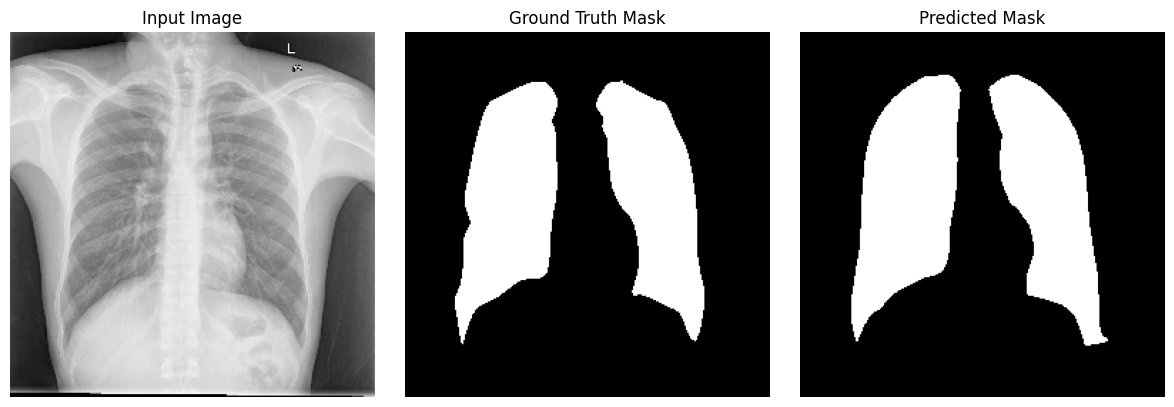

In [13]:
import torch, matplotlib.pyplot as plt, random, os, cv2, numpy as np, torch.nn as nn
from ultralytics import SAM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_img_dir = "/content/PC3_data/PC3_data_split/test/images"
test_mask_dir = "/content/PC3_data/PC3_data_split/test/masks"

class XrayDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, self.masks[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        img = img.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)
        img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), torch.tensor(mask).unsqueeze(0)

test_dataset = XrayDataset(test_img_dir, test_mask_dir)
base_sam = SAM("sam2.1_l.pt")
sam_model = base_sam.model.to(device)

with torch.no_grad():
    sample_x, _ = test_dataset[0]
    sample_x = sample_x.unsqueeze(0).to(device)
    feats = sam_model.image_encoder(sample_x)
    if isinstance(feats, dict):
        feats = list(feats.values())[0]
    feat_channels = feats.shape[1]

class FineTuneSAM(nn.Module):
    def __init__(self, sam_base, in_channels, out_size=(256, 256)):
        super().__init__()
        self.encoder = sam_base.image_encoder
        self.out_size = out_size
        self.dec = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)
        )
    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
            if isinstance(features, dict):
                feats = list(features.values())[0]
            else:
                feats = features
        out = self.dec(feats)
        out = nn.functional.interpolate(out, size=self.out_size, mode='bilinear', align_corners=False)
        return torch.sigmoid(out)

model = FineTuneSAM(sam_model, in_channels=feat_channels, out_size=(256, 256)).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/sam2L_finetuned_xray.pt", map_location=device))
model.eval()

idx = random.randint(0, len(test_dataset) - 1)
img, mask = test_dataset[idx]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(img).cpu().squeeze().numpy()

img_disp = img.cpu().squeeze().permute(1, 2, 0).numpy()
mask_disp = mask.squeeze().numpy()
pred_disp = (pred > 0.5).astype(float)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img_disp); plt.title("Input Image"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(mask_disp, cmap="gray"); plt.title("Ground Truth Mask"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(pred_disp, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.tight_layout(); plt.show()


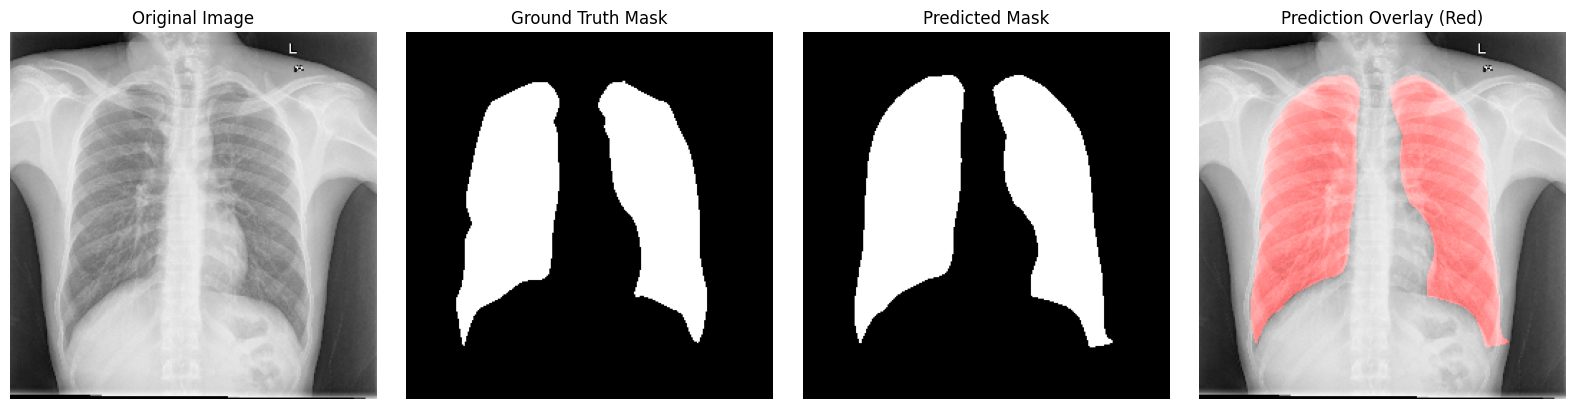

In [14]:
import matplotlib.pyplot as plt
import numpy as np



overlay = img_disp.copy()
overlay[..., 0] += pred_disp * 0.5  # Red channel
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(img_disp)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(mask_disp, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred_disp, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(overlay)
plt.title("Prediction Overlay (Red)")
plt.axis("off")

plt.tight_layout()
plt.show()
